In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [5]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
RADI = torch.from_numpy(np.load(data_path + '/radi.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 100
NUM_HIDDEN = 64
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()

In [6]:
from decoder import *
dec_x = Dec_x(2, NUM_HIDDEN, CUDA)
recon_sigma = torch.ones((BATCH_SIZE, N, D)) * 0.1
if CUDA:
    dec_x.cuda()
    recon_sigma = recon_sigma.cuda()
optimizer =  torch.optim.Adam(list(dec_x.parameters()), lr=LEARNING_RATE, betas=(0.9, 0.99))

In [10]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    LOSS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        state = STATE[batch_indices]
        mu = MU[batch_indices]
        radi = RADI[batch_indices]
        angle = ANGLE[batch_indices]
        
        labels = state.argmax(-1).unsqueeze(-1).repeat(1, 1, D)
        mu_copy = torch.gather(mu, 1, labels)
        ob_embedding = torch.cat((ob, mu_copy, radi, angle), -1)

        ob_embedding = shuffler(ob_embedding)
        if CUDA:
            ob_embedding =ob_embedding.cuda()
        ob = ob_embedding[:, :, :2]
        embedding = ob_embedding[:, :, 2:]
        p = dec_x(ob, embedding, recon_sigma)
        loss =  - p['likelihood'].log_prob.sum()
        ## gradient step
        loss.backward()
        optimizer.step()  
        LOSS += loss
    time_end = time.time()
    print('epoch=%d, loss=%.4f (%ds)' % (epoch, LOSS / NUM_BATCHES, time_end - time_start))

epoch=0, loss=-8658.3457 (0s)
epoch=1, loss=-8525.2852 (0s)
epoch=2, loss=-8625.6396 (0s)
epoch=3, loss=-8631.1963 (0s)
epoch=4, loss=-8641.7812 (0s)
epoch=5, loss=-8710.5840 (0s)
epoch=6, loss=-8575.8965 (0s)
epoch=7, loss=-8738.3975 (0s)
epoch=8, loss=-8565.2070 (0s)
epoch=9, loss=-8692.8916 (0s)
epoch=10, loss=-8712.8613 (0s)
epoch=11, loss=-8730.4814 (0s)
epoch=12, loss=-8729.4883 (0s)
epoch=13, loss=-8735.2852 (0s)
epoch=14, loss=-8645.3115 (0s)
epoch=15, loss=-8772.6895 (0s)
epoch=16, loss=-8790.3936 (0s)
epoch=17, loss=-8757.2529 (0s)
epoch=18, loss=-8799.8975 (0s)
epoch=19, loss=-8818.5557 (0s)
epoch=20, loss=-8760.3164 (0s)
epoch=21, loss=-8767.6934 (0s)
epoch=22, loss=-8866.6865 (0s)
epoch=23, loss=-8685.4590 (0s)
epoch=24, loss=-8894.3125 (0s)
epoch=25, loss=-8848.7490 (0s)
epoch=26, loss=-8896.1387 (0s)
epoch=27, loss=-8750.1006 (0s)
epoch=28, loss=-8862.3350 (0s)
epoch=29, loss=-8851.2900 (0s)
epoch=30, loss=-8738.6680 (0s)
epoch=31, loss=-8795.2441 (0s)
epoch=32, loss=-89

KeyboardInterrupt: 

In [25]:
def plot_rings_v2(obs, states, recon_mu, K, bound):
    colors = ['r', 'b', 'g', 'k', 'y']
    assignments = states.argmax(-1)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    for k in range(K):
        obs_k = obs[np.where(assignments==k)]
        recon_mu_k = recon_mu[np.where(assignments==k)]
        ax.scatter(obs_k[:,0], obs_k[:, 1], s=5, c=colors[k], alpha=0.8)
        ax.scatter(recon_mu_k[:,0], recon_mu_k[:, 1], s=5, c='k', alpha=0.2)
    ax.set_xlim([-bound, bound])
    ax.set_ylim([-bound, bound])

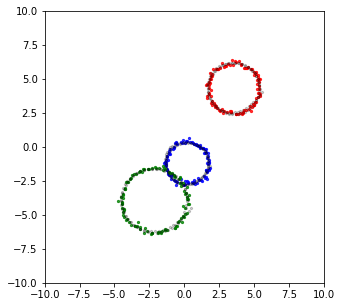

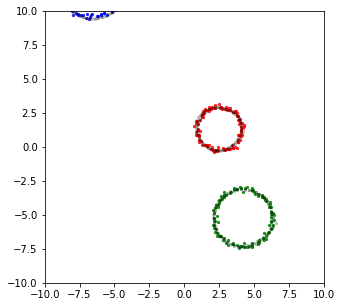

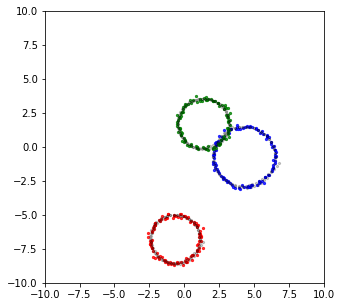

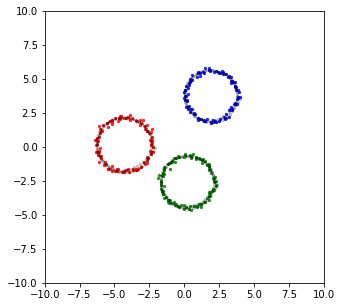

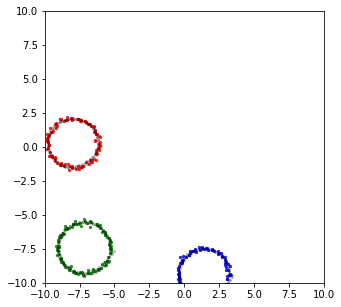

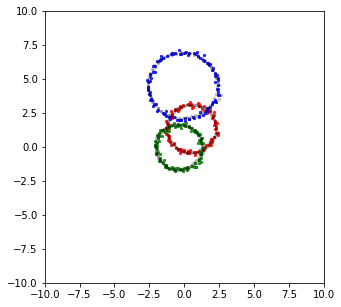

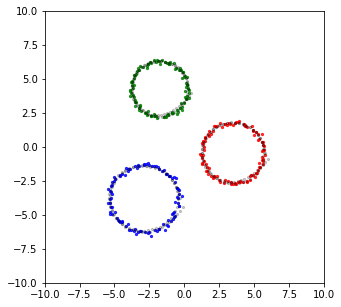

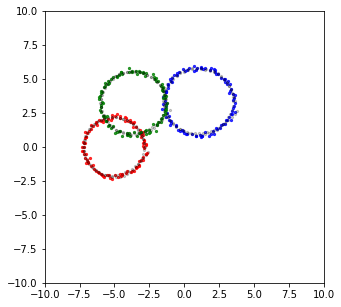

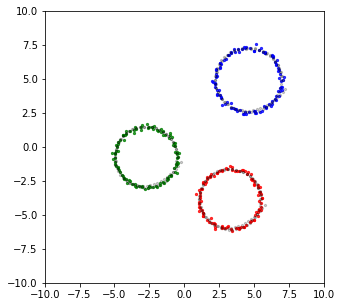

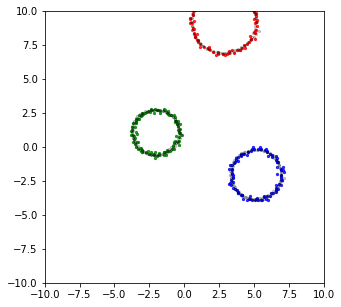

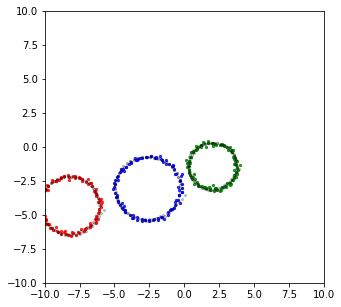

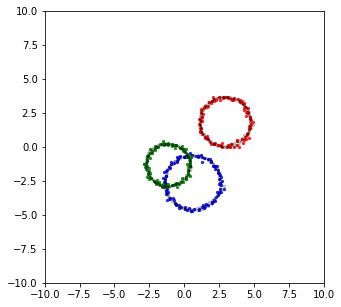

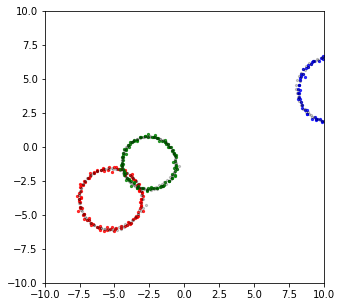

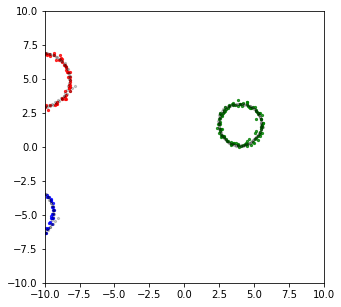

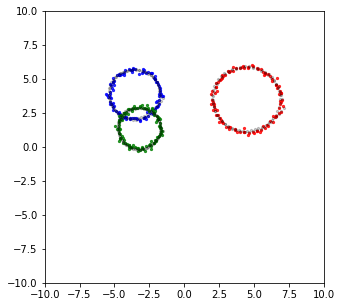

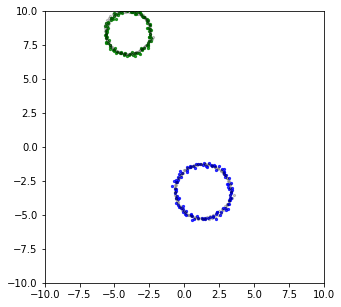

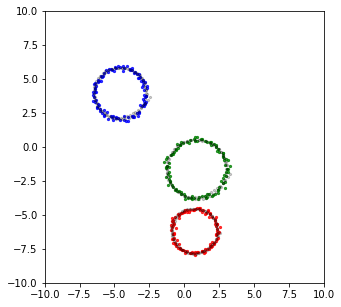

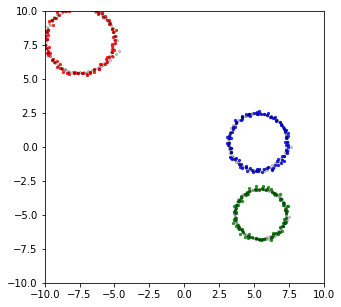

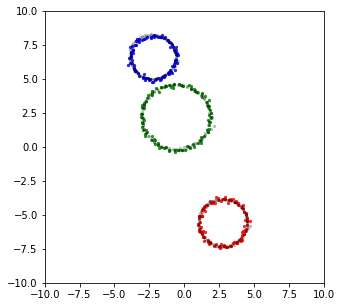

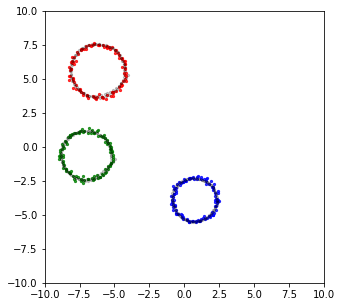

In [26]:
indices = torch.randperm(NUM_DATASETS)
for step in range(NUM_BATCHES):
    optimizer.zero_grad()
    batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
    ob = OB[batch_indices]
    state = STATE[batch_indices]
    mu = MU[batch_indices]
    radi = RADI[batch_indices]
    angle = ANGLE[batch_indices]

    labels = state.argmax(-1).unsqueeze(-1).repeat(1, 1, D)
    mu_copy = torch.gather(mu, 1, labels)
    ob_state_embedding = torch.cat((ob, state, mu_copy, radi, angle), -1)

    ob_state_embedding = shuffler(ob_state_embedding)
    if CUDA:
        ob_state_embedding =ob_state_embedding.cuda()
    ob = ob_state_embedding[:, :, :2]
    state = ob_state_embedding[:, :, 2:5]
    embedding = ob_state_embedding[:, :, 5:]
    p = dec_x(ob, embedding, recon_sigma)
    break
recon_mu = p['likelihood'].dist.loc.cpu().data.numpy()
for i in range(BATCH_SIZE):
    plot_rings_v2(ob[i].cpu().data.numpy(), state[i].cpu().data.numpy(), recon_mu[i], 3, 10)
